<a href="https://colab.research.google.com/github/ansonkwokth/TableTennisPrediction/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from model import rating_system
from utils import data_loader as dl

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Data

In [ ]:
GAME = 'TTStar'
# GAME = 'TTCup'
# GAME = 'SetkaCup'
# GAME = 'SetkaCupWomen'
# GAME = 'LigaPro'


In [ ]:
if GAME == 'TTStar':
    years = [2020, 2021, 2022, 2023, 2024]
elif GAME == 'TTCup':
    years = [2020, 2021, 2022, 2023, 2024]
elif GAME == 'SetkaCup':
    years = [2020, 2021, 2022, 2023, 2024]
elif GAME == 'SetkaCupWomen':
    years = [2020, 2021, 2022, 2023, 2024]
elif GAME == 'LigaPro':
    years = [2022, 2023, 2024]
else:
    raise ValueError("Invalid game selected.")


text_data_game = dl.load_game_data(GAME, years)
text_data = {
    year: text_data_game[year] for year in years
}
df = dl.create_game_dfs(GAME, years, text_data)

In [ ]:
# Generate ID indices for each pair of rows in the DataFrame
idx_lt = [i for i in range(len(df) // 2) for _ in range(2)]
df['ID'] = idx_lt  # Assign to the 'ID' column

# Reset the DataFrame index to ensure it's sequential
df.reset_index(drop=True, inplace=True)

# Get unique players and store them in player_lt
player_lt = df['Player'].unique()



In [ ]:
year_val = years[-2]
year_test = years[-1]

df_train = df.loc[pd.DatetimeIndex(df['Date']).year < year_val]
df_val = df.loc[pd.DatetimeIndex(df['Date']).year == year_val]
df_test = df.loc[pd.DatetimeIndex(df['Date']).year == year_test]

In [ ]:
def format_to_array(df: pd.DataFrame) -> np.ndarray:

    info_col = ['ID', 'Round', 'Datetime', 'Game', 'Date', 'Time']
    col = [item for item in df.columns if item not in info_col]

    df[[c for c in col if "Set" in c]] = df[[c for c in col if "Set" in c]].astype(float)
    X = df[col].values.reshape(-1, 2, len(col))
    return X

In [ ]:
X_train = format_to_array(df_train)
X_val = format_to_array(df_val)
X_test = format_to_array(df_test)

# Train and Evaluate

In [ ]:
model = rating_system.RatingSystem(learning_rate=0.1)
# model = RatingSystem(learning_rate=0.01, base_param=(0, 0.1))
# model = RatingSystem(learning_rate=0.01, base_param=(0, 0.1), update_sigma=False)
# model = RatingSystem(learning_rate=0.1, base_param=(0, 0.1), update_sigma=False)

# traing model with only training set
model.fit(X_train)


100%|██████████| 9867/9867 [00:00<00:00, 16959.30it/s]


In [ ]:
# evaluate the model with the training set
model.evaluate(X_train);
# evaluate the model with the evaluating set
model.evaluate(X_val);


100%|██████████| 9867/9867 [00:00<00:00, 16064.53it/s]



 === Accuracy: 0.7429816560251343 === 



100%|██████████| 4451/4451 [00:00<00:00, 13175.63it/s]


 === Accuracy: 0.670345151444001 === 



In [ ]:
# define a new model, and import the pre-trained params from the training set
model_test = rating_system.RatingSystem(learning_rate=0.1)
model_test.params = model.params

# training the model again with the evaluating set, on top of the pre-trained params
model_test.fit(X_val)

# evaluate the model with the testing set
aacc, history, predictions = model_test.evaluate(X_test)

100%|██████████| 2939/2939 [00:00<00:00, 11121.36it/s]


 === Accuracy: 0.6908383445348426 === 



Text(0, 0.5, 'Pred')

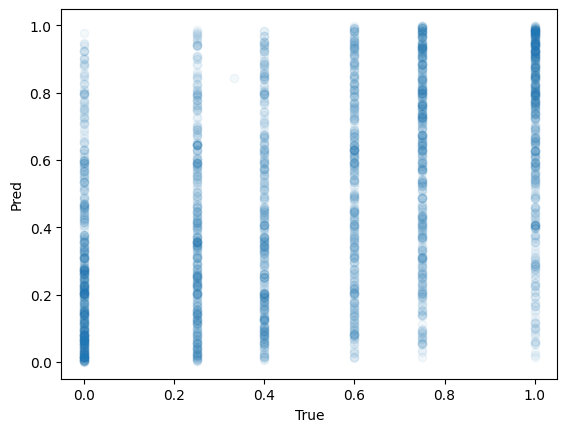

In [ ]:
plt.scatter(history, predictions, alpha=0.05)
plt.xlabel("True")
plt.ylabel("Pred")

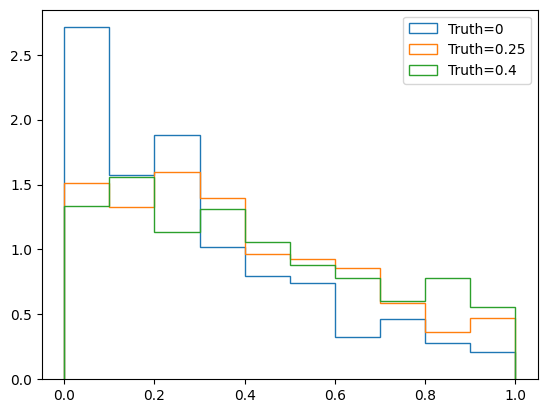

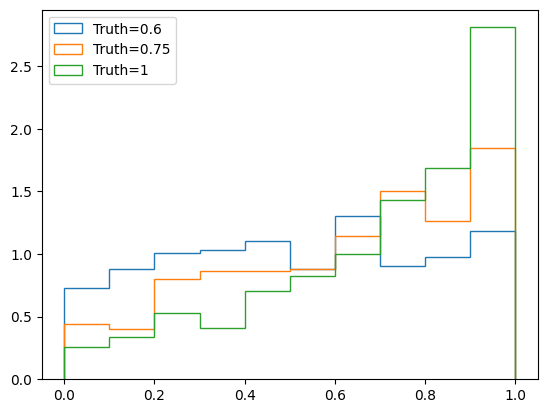

In [ ]:
bins_=10
history_p = [0, 0.25, 0.4, 0.6, 0.75, 1]
for p in history_p[:3]:
    plt.hist(predictions[history == p], range=[0, 1], bins=bins_, histtype='step', density=True, label=f"Truth={p}");

plt.legend();
plt.show()

for p in history_p[3:]:
    plt.hist(predictions[history == p], range=[0, 1], bins=bins_, histtype='step', density=True, label=f"Truth={p}");

plt.legend();
plt.show()

# Influence

In [35]:
player1 = 'Folwarski J.'
player2 = 'Brossier B.'

p_point = model_test.predict_point(player1, player2)
p_set = model_test.predict_set(player1, player2)
p_game = model_test.predict_game(player1, player2)

In [36]:
print(f"p({player1} wins a point)  = {p_point:.2f}")
print(f"p({player1} wins a set)    = {p_set:.2f}")
print(f"p({player1} wins the game) = {p_game:.2f}")

p(Folwarski J. wins a point)  = 0.53
p(Folwarski J. wins a set)    = 0.62
p(Folwarski J. wins the game) = 0.72


In [41]:
ps_set = model_test.predict_set_config(player1, player2)

for points, p in ps_set.items():
    print(f"p({player1} wins a set with total points={points}) = {p:.4f}")

p(Folwarski J. wins a set with total points=11) = 0.0010
p(Folwarski J. wins a set with total points=12) = 0.0050
p(Folwarski J. wins a set with total points=13) = 0.0139
p(Folwarski J. wins a set with total points=14) = 0.0283
p(Folwarski J. wins a set with total points=15) = 0.0463
p(Folwarski J. wins a set with total points=16) = 0.0650
p(Folwarski J. wins a set with total points=17) = 0.0812
p(Folwarski J. wins a set with total points=18) = 0.0923
p(Folwarski J. wins a set with total points=19) = 0.0972
p(Folwarski J. wins a set with total points=20) = 0.0961
p(Folwarski J. wins a set with total points=22) = 0.0953


In [43]:
# by defalt, who wins 3 sets will win the game
ps_game = model_test.predict_game_config(player1, player2)

for points, p in ps_game.items():
    print(f"p({player1} wins the game with total sets={points}) = {p:.4f}")

p(Folwarski J. wins the game with total sets=3) = 0.2401
p(Folwarski J. wins the game with total sets=4) = 0.2726
p(Folwarski J. wins the game with total sets=5) = 0.2063


In [45]:
# if the rule of the game is: who wins 5 sets will win the game
n_win_sets = 5
ps_game = model_test.predict_game_config(player1, player2, n_win_sets)

for points, p in ps_game.items():
    print(f"p({player1} wins the game with total sets={points}) = {p:.4f}")

p(Folwarski J. wins the game with total sets=5) = 0.0928
p(Folwarski J. wins the game with total sets=6) = 0.1755
p(Folwarski J. wins the game with total sets=7) = 0.1993
p(Folwarski J. wins the game with total sets=8) = 0.1760
p(Folwarski J. wins the game with total sets=9) = 0.1332
